# Linear regression and random forest

This script provides a first analysis of the bridge dataset using linear regression and random forest models. 

However, especially the linear regression model is not well suited for this dataset resulting in a very low $R^2$ value. The random forest model performs better, but still leaves room for improvement.



In [14]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier


In [ ]:
# read data
data = pd.read_csv('../../data/final_bridge_statistic_germany.csv', sep=';')
# preprocess data
data = data.dropna()

# one-hot encode categorical variables
type_encoded = pd.get_dummies(data['Teilbauwerksart'])
stadium_encoded = pd.get_dummies(data['Teilbauwerksstadium'])
superstructure_encoded = pd.get_dummies(data['Baustoff Überbau'])
federal_state_encoded = pd.get_dummies(data['Bundeslandname'])
region_encoded = pd.get_dummies(data['Kreis'])
steet_type_encoded = pd.get_dummies(data['Zugeordneter Sachverhalt vereinfacht'])

In [ ]:

# get x, exclude non numeric columns
x = data.select_dtypes(include=['number'])

# add encoded columns to x 
x = pd.concat([x, type_encoded, stadium_encoded, superstructure_encoded, federal_state_encoded, region_encoded, steet_type_encoded], axis=1)
# drop unnecessary columns
x = x.drop(columns=['Unnamed: 0'])
# drop target column from x
x = x.drop(columns=["Zustandsnote"])


# get targets y 
y = data["Zustandsnote"]

Mean Squared Error: 0.13960885676233822
R^2 score: 0.32654376178291844


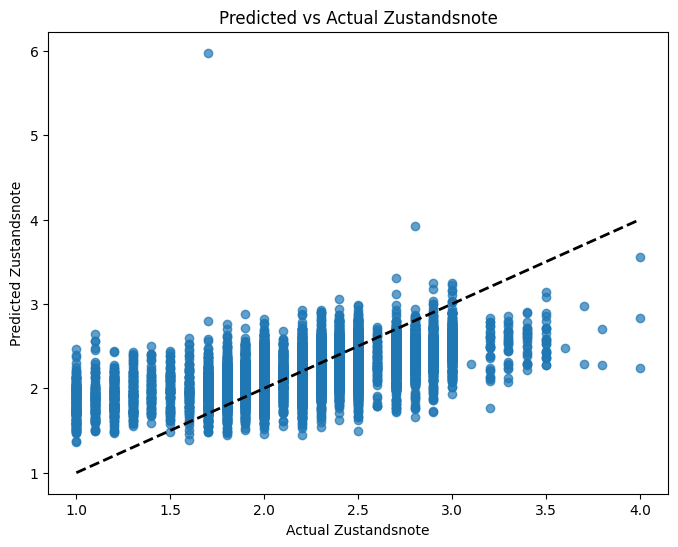

In [8]:
# split data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

#scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# train linear regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)


y_pred = model.predict(X_test_scaled)
score = model.score(X_test_scaled, y_test)
error = np.mean((y_pred - y_test) ** 2)
print("Mean Squared Error:", error)
print("R^2 score:", score)

# plot predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual Zustandsnote")
plt.ylabel("Predicted Zustandsnote")
plt.title("Predicted vs Actual Zustandsnote")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.show()


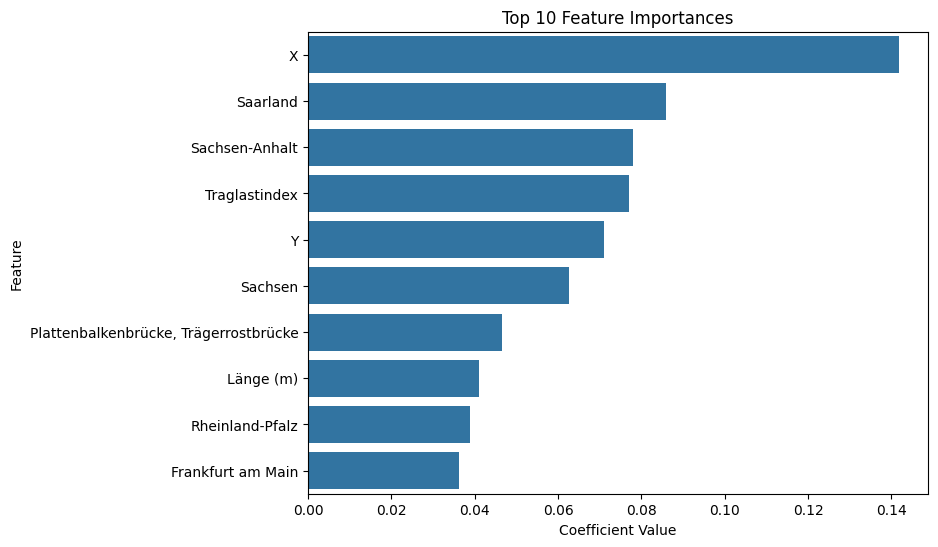

In [9]:
# plot feature importance of linear regression model (10 most important features)


importance = model.coef_
feature_names = X_train.columns
feature_importance = pd.Series(importance, index=feature_names).sort_values(ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(x=feature_importance.values[:10], y=feature_importance.index[:10])
plt.title("Top 10 Feature Importances")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()

Because of the poor performance of this model, we decided to try Random Forest.

### Random Forest 

Random Forest R^2: 0.42024784586984065


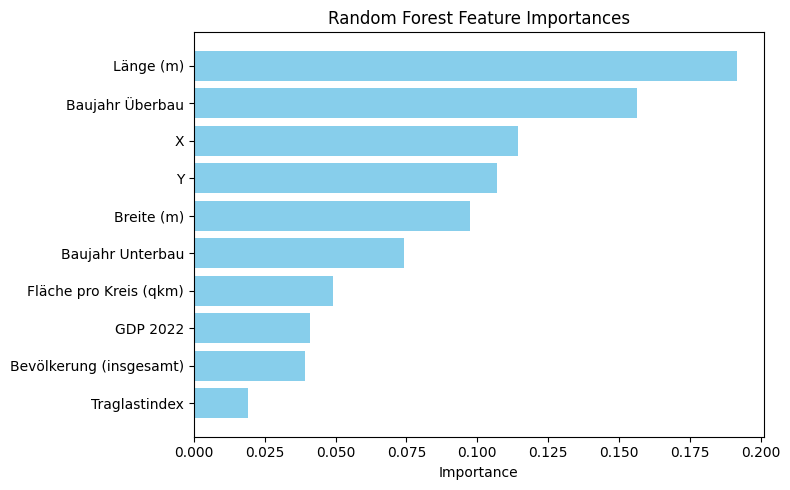

In [13]:
# train random forest 
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# get feature importance 
importances = rf.feature_importances_
feature_names = X_train.columns
sorted_indices = importances.argsort()[::-1]
print("Random Forest R^2:", rf.score(X_test, y_test))
    
# Plot feature importances
indices = np.argsort(importances)[-10:] # 10 most important features

plt.figure(figsize=(8, 5))
plt.barh([feature_names[i] for i in indices], importances[indices], color='skyblue')
plt.xlabel('Importance')
plt.title('Random Forest Feature Importances')
plt.tight_layout()
plt.show()



Compared to the linear regression model, the random forest model achieves a significantly higher $R^2$ value on the test set. This indicates that the random forest model is better at capturing the underlying patterns in the data and provides more accurate predictions of the bridge condition scores.

### Random Forest with Zustandsnotenbereich (= condition score range) as target variable

In this part of the analysis, we use the Zustandsnotenbereich (condition score range) instead of the exact Zustandsnote (condition score) as the target variable for the random forest model. The Zustandsnotenbereich groups the condition scores into broader categories, which may help improve the model's performance by reducing noise in the target variable.

In [ ]:
# The bins for the Zustandsnotenbereich are defined as follows: 
bins = [1.0, 1.4, 1.9, 2.4, 2.9, 3.4, 4.0]


data['Zustandsnotenbereich'] = pd.cut(
    data['Zustandsnote'],
    bins=bins,
    right=True,       # 1.4 belongs to "very good condition", etc.
    include_lowest=True
)

# data preparation
# get x, exclude non numeric columns
x_categorial = data.select_dtypes(include=['number'])
# add encoded columns to x
x_categorial = pd.concat([x_categorial, type_encoded, stadium_encoded, superstructure_encoded, federal_state_encoded, steet_type_encoded], axis=1)
# drop unnecessary columns
x_categorial = x_categorial.drop(columns=['Unnamed: 0'])
# drop target column from x
x_categorial = x_categorial.drop(columns=["Zustandsnote"])
# get target variable as categorical codes
y_categorial = data["Zustandsnotenbereich"].cat.codes  # Convert categories to integer codes



X_train, X_test, y_train, y_test = train_test_split(x_categorial, y_categorial, test_size=0.2, random_state=42)
scaler = StandardScaler()

# scale features 
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)




In [15]:
# train random forest classsifier
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
print("Random Forest Classifier R^2:", rf_model.score(X_test, y_test))


Random Forest Classifier R^2: 0.572037056756469


Compared to the first random forest model using the exact Zustandsnote, this model achieves an even higher $R^2$ value on the test set. 

In [16]:
# feature importance 
importances = rf_model.feature_importances_
top_n = 10
top_indices = importances.argsort()[-top_n:]
for i in reversed(top_indices):
    print(f"{X_train.columns[i]}: {importances[i]:.3f}")


Länge (m): 0.105
Baujahr Überbau: 0.099
X: 0.096
Baujahr Unterbau: 0.094
Y: 0.094
Breite (m): 0.092
Fläche pro Kreis (qkm): 0.060
GDP 2022: 0.058
Bevölkerung (insgesamt): 0.058
Traglastindex: 0.043


A classification report is also provided. What stands out here is the high precision and recall for the middle categories, while the extreme categories have lower scores. This could be due to class imbalance. 

In [ ]:
print(classification_report(y_test, rf_model.predict(X_test)))


              precision    recall  f1-score   support

           0       0.48      0.35      0.40       649
           1       0.44      0.35      0.39      1536
           2       0.61      0.74      0.67      4594
           3       0.52      0.46      0.49      2203
           4       0.47      0.27      0.34       378
           5       0.24      0.13      0.17        31

    accuracy                           0.56      9391
   macro avg       0.46      0.38      0.41      9391
weighted avg       0.55      0.56      0.55      9391

[[ 227  163  242   17    0    0]
 [ 146  535  757   98    0    0]
 [  94  441 3388  639   32    0]
 [  10   78 1025 1009   77    4]
 [   0    3  106  159  101    9]
 [   0    0    7   17    3    4]]
